<a href="https://colab.research.google.com/github/TsvetaIvanova/ColabIMLO/blob/main/OffIMLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running instructions

## imports

In [ ]:
import pandas as pd
from sklearn import datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, transforms
import time
from PIL import Image
from scipy.io import loadmat
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from google.colab import runtime
from google.colab import drive


#Get full dataset into dataframe


In [ ]:
print(torch.__version__)
# !pip install torch==2.2.2

2.2.1+cu121


# Get and process data


In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [ ]:

data_train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    #transforms.Normalize(mean=([0.5014, 0.4112, 0.3327]), std=([0.2578, 0.2079, 0.2205]))
])

data_val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    #transforms.Normalize(mean=([0.5014, 0.4112, 0.3327]), std=([0.2578, 0.2079, 0.2205]))
])

data_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    #transforms.Normalize(mean=([0.5014, 0.4112, 0.3327]), std=([0.2578, 0.2079, 0.2205]))
])





In [ ]:
def show_image(dataset, index=0):
    image, label = dataset[index]
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.show()




In [ ]:
train_set = datasets.Flowers102(root='data', split='train', download=True, transform=data_train_transform)
test_set = datasets.Flowers102(root='data', split='test', download=True, transform=data_test_transform)
val_set = datasets.Flowers102(root='data', split='val', download=True, transform=data_val_transform)


# creating data loaders

train_loader = DataLoader(dataset=train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
val_loader = DataLoader(dataset=val_set, batch_size=16, shuffle=False)


100%|██████████| 344862509/344862509 [00:16<00:00, 20834213.65it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 609418.41it/s]


100%|██████████| 14989/14989 [00:00<00:00, 9643875.23it/s]


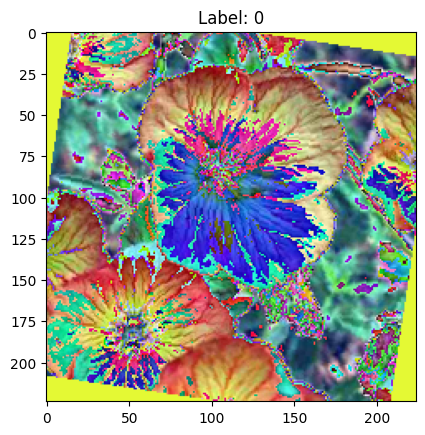

In [ ]:
show_image(train_set)

## using the datasets.Flowers102 function

# preprocess data for training


# Test

# NN Architecture(Neural Network)


## define the model

In [ ]:

# # 37% not too bad
# class ConvNN(nn.Module):
#     def __init__(self, hidden_units=128):
#         super(ConvNN, self).__init__()
#         self.hidden_units = hidden_units
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.conv3 = nn.Conv2d(64, hidden_units, kernel_size=3, stride=1, padding=1)
#         self.conv4 = nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.bn3 = nn.BatchNorm2d(hidden_units)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.fc1 = nn.Linear(hidden_units * 14 * 14, 512)
#         self.fc2 = nn.Linear(512, 102)
#         self.dropout2 = nn.Dropout(0.5)

#     def forward(self, x):
#         x = F.relu(self.bn1(self.conv1(x)))
#         x = self.pool(x)
#         x = F.relu(self.bn2(self.conv2(x)))
#         x = self.pool(x)
#         x = F.relu(self.bn3(self.conv3(x)))
#         x = self.pool(x)
#         x = F.relu(self.conv4(x))
#         # print(x.shape)
#         x = x.view(-1, self.hidden_units * 14 * 14)  # flatten
#         x = F.relu(self.fc1(x))
#         x = self.dropout2(x)
#         x = self.fc2(x)
#         return x


# Simplified, for now it performs best, 45%

# class ConvNN(nn.Module):
#     def __init__(self):
#         super(ConvNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm2d(128)
#         self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
#         self.bn3 = nn.BatchNorm2d(256)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.fc1 = nn.Linear(256 * 14 * 14, 512)
#         self.dropout1 = nn.Dropout(0.7)
#         self.fc2 = nn.Linear(512, 102)

#     def forward(self, x):
#         x = F.relu(self.bn1(self.pool(self.conv1(x))))
#         x = F.relu(self.bn2(self.pool(self.conv2(x))))
#         x = F.relu(self.bn3(self.pool(self.conv3(x))))
#         # print(x.shape)
#         x = x.view(-1, 256 * 14 * 14)
#         x = F.relu(self.fc1(self.dropout1(x)))
#         x = self.fc2(x)
#         return x



# a good one use this first next
# class ConvNN(nn.Module):
#     def __init__(self):
#         super(ConvNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm2d(128)
#         self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
#         self.bn3 = nn.BatchNorm2d(256)
#         self.pool = nn.MaxPool2d(2, 2)
#         # Adjusting the fully connected layer to account for the new flattened size:
#         self.fc1 = nn.Linear(128 * 56 * 56, 512)  # Example adjustment, calculate based on actual output size
#         self.dropout1 = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(512, 102)

#     def forward(self, x):
#         x = F.relu(self.bn1(self.pool(self.conv1(x))))
#         x = F.relu(self.bn2(self.pool(self.conv2(x))))
#         x = F.relu(self.bn3(self.pool(self.conv3(x))))
#         # print(x.shape)
#         x = x.view(-1, 128 * 56 * 56)  # Adjust this based on your pooling and convolutional layers
#         x = F.relu(self.fc1(self.dropout1(x)))
#         x = self.fc2(x)
#         return x




# # Define the model with dropout
# class ConvNN(nn.Module):
#     def __init__(self):
#         super(ConvNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.dropout1 = nn.Dropout(0.5)  # Added dropout layer
#         self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm2d(128)
#         self.dropout2 = nn.Dropout(0.5)  # Added dropout layer
#         self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
#         self.bn3 = nn.BatchNorm2d(256)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.fc1 = nn.Linear(256 * 14 * 14, 512)
#         self.fc2 = nn.Linear(512, 102)

#     def forward(self, x):
#         x = self.pool(F.relu(self.bn1(self.conv1(x))))
#         x = self.dropout1(x)  # Apply dropout after activation
#         x = self.pool(F.relu(self.bn2(self.conv2(x))))
#         x = self.dropout2(x)  # Apply dropout after activation
#         x = self.pool(F.relu(self.bn3(self.conv3(x))))
#         x = x.view(-1, 256 * 14 * 14)  # Flatten
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# testing a new one 13-05

class ConvNN(nn.Module):
    def __init__(self):
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        self.bn5 = nn.BatchNorm1d(1024)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 102)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 512 * 14 * 14)
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



# class ConvNN(nn.Module):


#     def __init__(self, hidden_units=128):
#          super(ConvNN, self).__init__()
#          self.hidden_units=hidden_units
#          self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=(1, 1), padding=1, bias=True)
#          self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=(1, 1), padding=1, bias=True)
#          self.conv3 = nn.Conv2d(64, hidden_units, kernel_size=3, stride=(1, 1), padding=1, bias=True)
#         #  self.conv4 = nn.Conv2d(hidden_units, 256, kernel_size=3, stride=(1, 1), padding=1, bias=True)
#         #  self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=(1, 1), padding=1, bias=True)

#          self.bn1 = nn.BatchNorm2d(32)
#          self.bn2 = nn.BatchNorm2d(64)
#          self.bn3 = nn.BatchNorm2d(hidden_units)
#         #  self.bn4 = nn.BatchNorm2d(256)
#         #  self.bn5 = nn.BatchNorm2d(512)

#          self.pool = nn.MaxPool2d(2, 2, padding=0)
#          self.fc1 = nn.Linear(hidden_units * 28 * 28, 512)
#          self.fc2 = nn.Linear(512, 102)
#          self.dropout1 = nn.Dropout(0.5)



#     def forward(self, x):
#         x = self.pool(F.relu(self.bn1(self.conv1(x))))
#         # x = F.relu(self.conv1(x))
#         x = self.pool(F.relu(self.bn2(self.conv2(x))))
#         # x = F.relu(self.conv3(x))
#         x = self.pool(F.relu(self.bn3(self.conv3(x))))
#         # x = self.pool(F.relu(self.bn4(self.conv4(x))))
#         # x = self.pool(F.relu(self.bn5(self.conv5(x))))
#         # print(x.shape)
#         x = x.view(-1, self.hidden_units * 28 * 28) # Flatten the output for the dense layer
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)
#         x = self.fc2(x)
#         return x





In [ ]:
# def train(dataloader, model, loss_fn, optimizer):
#     total_loss = 0
#     model.train()
#     for batch, (X, y) in enumerate(dataloader):
#         X, y = X.to(device), y.to(device)

#         optimizer.zero_grad()
#         outputs = model(X)
#         loss = loss_fn(outputs, y)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#         if batch % 10 == 0:
#             print(f'Epoch {t+1}, Batch {batch}, Loss: {loss.item():.4f}')

#         # Time each batch processing
#         if batch == 0:
#             start_time = time.time()
#         elif batch == 1:
#             elapsed_time = time.time() - start_time
#             print(f"Time per batch: {elapsed_time:.2f} seconds")

#     average_loss = total_loss / len(dataloader)
#     print(f'Average Loss: {average_loss:.4f}')


    # Training function
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if batch % 10 == 0:
            print(f'Epoch {t+1}, Batch {batch}, Loss: {loss.item():.4f}')
        if batch == 0:
            start_time = time.time()
        elif batch == 1:
            elapsed_time = time.time() - start_time
            print(f"Time per batch: {elapsed_time:.2f} seconds")

    average_loss = total_loss / len(dataloader)
    print(f'Average Loss: {average_loss:.4f}')


In [ ]:
# def test(dataloader, model, loss_fn):
#     size = len(dataloader.dataset)
#     num_batches = len(dataloader)
#     model.eval()
#     test_loss, correct = 0, 0
#     with torch.no_grad():
#         for X, y in dataloader:
#             X, y = X.to(device), y.to(device)
#             pred = model(X)
#             test_loss += loss_fn(pred, y).item()
#             correct += (pred.argmax(1) == y).type(torch.float).sum().item()
#     test_loss /= num_batches
#     correct /= size
#     print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Testing function
def test(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss  # Ensure this value is returned


In [ ]:
model = ConvNN().to(device)
print(model)

# LossFN
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)  # Added L2 regularization
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10)



ConvNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=102, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
)


# Train and Evaluation


In [ ]:
# epochs = 500
# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     train(train_loader, model, loss_fn, optimizer)
#     if t >= 19:
#       test(val_loader, model, loss_fn)
# print("Done!")

# Training and evaluation loop
epochs = 500
for t in range(epochs):
    print(f"Epoch {t+1}/{epochs},\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    if t >= 19:
      val_loss = test(val_loader, model, loss_fn)
      scheduler.step(val_loss)

    # Checkpointing every 100 epochs
    if t % 100 == 0 and t != 0:
        torch.save(model.state_dict(), f'model_epoch_{t}.pth')
        print(f'Checkpoint saved at epoch {t}')

print("Done!")


Epoch 1/500,
-------------------------------
Epoch 1, Batch 0, Loss: 4.7071
Time per batch: 0.40 seconds
Epoch 1, Batch 10, Loss: 5.1118
Epoch 1, Batch 20, Loss: 4.8898
Epoch 1, Batch 30, Loss: 4.4857
Average Loss: 4.7401
Epoch 2/500,
-------------------------------
Epoch 2, Batch 0, Loss: 4.4488
Time per batch: 0.27 seconds
Epoch 2, Batch 10, Loss: 4.5640
Epoch 2, Batch 20, Loss: 4.0740
Epoch 2, Batch 30, Loss: 4.6080
Average Loss: 4.3214
Epoch 3/500,
-------------------------------
Epoch 3, Batch 0, Loss: 4.0342
Time per batch: 0.29 seconds
Epoch 3, Batch 10, Loss: 4.2527
Epoch 3, Batch 20, Loss: 3.9191
Epoch 3, Batch 30, Loss: 4.0550
Average Loss: 4.0800
Epoch 4/500,
-------------------------------
Epoch 4, Batch 0, Loss: 3.9326
Time per batch: 0.27 seconds
Epoch 4, Batch 10, Loss: 3.8815
Epoch 4, Batch 20, Loss: 3.8427
Epoch 4, Batch 30, Loss: 3.8487
Average Loss: 3.8355
Epoch 5/500,
-------------------------------
Epoch 5, Batch 0, Loss: 3.7891
Time per batch: 0.28 seconds
Epoch 5

## split and format the dataset

## Create a checkpoint for the training and testing in case I have to pause

## Create a visualisation

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

In [ ]:
model = ConvNN().to(device)
model.load_state_dict(torch.load("model.pth"))

## Set training parameters

## train

# Eval

In [ ]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')


In [ ]:

drive.mount('/content/drive')

In [ ]:
runtime.unassign()